In [1]:
# Here we are trying to calcualte the spatial energy per frame

In [2]:
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cmath

In [3]:
# Definitions:

def bin_averages(bins, array):
    """bins = contains number of lines to average in each bin, dump_bin
       array = contains TE, KE, PE array with each column representing frames"""
    start_idx = 0
    arr_avg = []
    for interval in bins:
        end_idx = start_idx + interval
        subset = array[start_idx:end_idx]
        avg = np.mean(subset, axis=0)
        arr_avg.append(avg)
        start_idx = end_idx
    return np.array(arr_avg)

In [4]:
# Input variables:
Total_frames = 41                      # No. of KE.*.txt files
start_index = 1                       # for KE_1.txt, 1, for KE_0.txt, 0
skip_frame = 3                        # No. of columns to skip at the end while plotting

N_bins = 50                         # use 200, number of bins to be used
ene_avg_freq = 3                     # Averaging this many frames
relaxid = "388586"
dump_ref_ene = "baseline_energy_388586.lmc" # Contains information of baseline energy/atom

N_atoms = 681120         # Number of atoms
N_layeratom = 360        # Number of atoms in each Au(111) layer N_atoms/N_layer
offset_p = 38            # Lines to skip in data file

In [5]:
# Reading the baseline_energy dump file:
with open(dump_ref_ene, "r") as file:
    elines = file.readlines()
    eline = elines[11:]

    dump_ref = np.array([list(map(float, line.strip().split())) for line in eline])
    sorted_index = np.argsort(dump_ref[:, -4])   # Z_position    
    dump_ref = dump_ref[sorted_index]            # All the dump values sorted a/c to Z-position
#     print("Shape of position:", dump_pos.shape)
    Z_pos_ref = dump_ref[:, -4]
    
# Extracting energies, sorted a/c to Z-position, low Z to high Z
    TE_ref = dump_ref[:, -1]
    KE_ref = dump_ref[:, -2]
    PE_ref = dump_ref[:, -3]

In [6]:
# Reading the values:
# create an empty list to store all kinetic energy values
KE_allframe = np.zeros((N_bins, Total_frames)) # 100 X 14(frames)

# loop through all the files
for i in range(0, Total_frames):
    # read the file
    with open(f'KE.{i+start_index}.txt') as f:
        print(f'Reading frame {i+start_index}')
        # skip the first two lines
        next(f)
        next(f)
        
        # read the remaining lines and extract the kinetic energy values
        KE = [list(map(float, line.strip().split())) for line in f] 
        KE = np.array(KE)
        
        # sort the kinetic energy values based on z-position
        KE_sorted = KE[np.argsort(KE[:, 0])]
        
        Z_pos = KE_sorted[:, 0]  # All the Z_position

        zlo = np.min(KE_sorted[:, 0])
        zhi = np.max(KE_sorted[:, 0])

        bin_width = (zhi-zlo)/N_bins         # in Angstrom
#         print("Number of bins:", N_bins, "Bin width:", bin_width, "A")

        bins = np.array([(zlo+i*bin_width) for i in range(N_bins)]);
        # print("First 3 bins:\n",[(bins[i], bins[i+1]) for i in range(len(bins)-1)][0:5])

        binned_data = {}                       # Dictionary
        for z in Z_pos:
            if z < zlo or z >= zhi:
                continue
            bin_num = (z - zlo) // bin_width;  # Calculates the bin numbers
            if bin_num in binned_data:
                binned_data[bin_num].append(z) # use the bin number and collect the z values
            else:
                binned_data[bin_num] = [z]   

        dump_bin = np.array([len(binned_data[i]) for i 
                             in range(len(binned_data))]) # calculates no. of lines to average

        # Averaging the reference energies:
        KE_avg_ref = bin_averages(dump_bin, KE_ref)
        PE_avg_ref = bin_averages(dump_bin, PE_ref)
        TE_avg_ref = bin_averages(dump_bin, TE_ref)

        # Now lets average the energies KEover the bins:
        KE_allframe[:, i] = bin_averages(dump_bin, KE_sorted[:, 1]); #print(KE_allframe[:, i].shape)
        Z_avg = bin_averages(dump_bin, Z_pos)     # Bin centers

Reading frame 1
Reading frame 2
Reading frame 3
Reading frame 4
Reading frame 5
Reading frame 6
Reading frame 7
Reading frame 8
Reading frame 9
Reading frame 10
Reading frame 11
Reading frame 12
Reading frame 13
Reading frame 14
Reading frame 15
Reading frame 16
Reading frame 17
Reading frame 18
Reading frame 19
Reading frame 20
Reading frame 21
Reading frame 22
Reading frame 23
Reading frame 24
Reading frame 25
Reading frame 26
Reading frame 27
Reading frame 28
Reading frame 29
Reading frame 30
Reading frame 31
Reading frame 32
Reading frame 33
Reading frame 34
Reading frame 35
Reading frame 36
Reading frame 37
Reading frame 38
Reading frame 39
Reading frame 40
Reading frame 41


In [7]:
# KE_allframe

Reading frame complete
Total columns: 41
Columns used for avg: 39


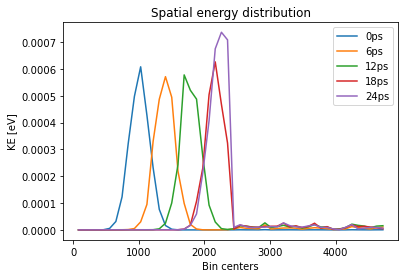

In [8]:
print("Reading frame complete")

print("Total columns:", KE_allframe.shape[1])
n_column = ene_avg_freq*(KE_allframe.shape[1]//ene_avg_freq); print("Columns used for avg:", n_column)

loop = int(n_column/ene_avg_freq); #print(loop)
col_bins = np.array([(i*ene_avg_freq) for i in range(int(loop+1))]); #print(col_bins)
Time_avg_KE = np.zeros((KE_allframe.shape[0], loop))
for i in range(int(loop)):
#     print((col_bins[i], col_bins[i+1]))
    Time_avg_KE[:, i] = np.mean(KE_allframe[:, col_bins[i]:col_bins[i+1]], axis=1)

# Saving all the data:
np.savetxt("KE_spatial_binavg_refene.dat", KE_avg_ref)
np.savetxt("PE_spatial_binavg_refene.dat", PE_avg_ref)
np.savetxt("TE_spatial_binavg_refene.dat", TE_avg_ref)
np.savetxt("KE_spatial_binavg.dat", KE_allframe)
np.savetxt("Time_avg_KE.dat", Time_avg_KE)

Time = np.arange(Time_avg_KE.shape[1])*2*ene_avg_freq
Time[0::skip_frame]
labels = [str(time) + "ps" for time in Time]
plt.plot(Z_avg, Time_avg_KE[:, 0::skip_frame], '-')
plt.xlabel('Bin centers')
plt.ylabel('KE [eV]')
plt.title('Spatial energy distribution')
plt.legend(labels)
plt.savefig("Spatial_KE_dist.png", dpi= 200, bbox_inches = 'tight', facecolor="w")
plt.show()